# Using STPSF

STPSF provides
five classes corresponding to the JWST instruments and two for the Roman instruments, with consistent interfaces. It also provides a variety of
supporting tools for measuring PSF properties and manipulating telescope state models.
See [this page](api_reference.html) for the detailed API; for now let's dive into some example code.

We begin by showing basic usage and describing the output data products, then discuss various ways to configure and customize PSF calculations.  [Additional code examples](more_examples.html) are available elsewhere in this documentation.


## Basic Usage and Examples

Simple PSFs are easily obtained.

Instantiate a model of `NIRCam`, set attributes to configure a particular observing mode, then call `calc_psf`:

In [1]:
%matplotlib inline
import matplotlib, matplotlib.pyplot as plt
import stpsf

In [2]:
nrc = stpsf.NIRCam()
nrc.filter =  'F200W'
psf = nrc.calc_psf(oversample=4)     # returns an astropy.io.fits.HDUlist containing PSF and header

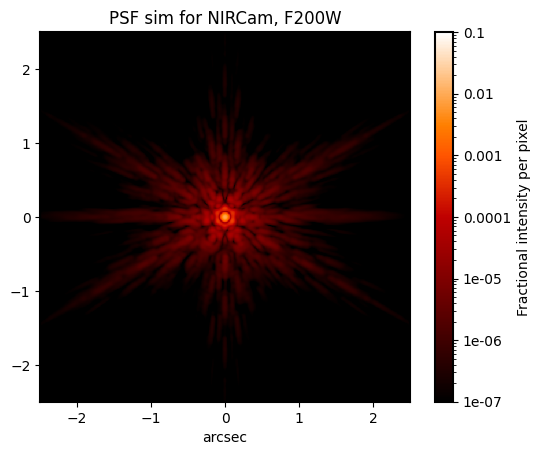

In [3]:
stpsf.display_psf(psf)            # use this convenient function to make a nice log plot with labeled axes

The returned PSF object is a FITS HDUList object, so you can examine, save, and generally manipulate them like any other HDUList. 

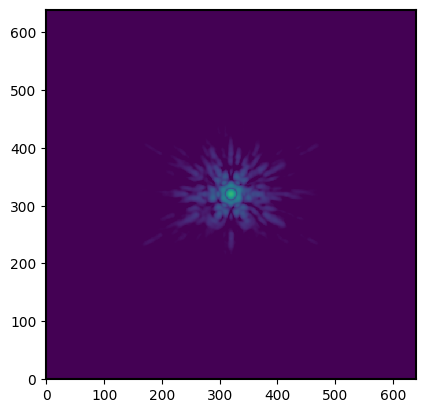

In [4]:
plt.imshow(psf[0].data, norm=matplotlib.colors.LogNorm(1e-6, 1))              # display it on screen yourself
psf.writeto('myPSF.fits', overwrite=True)  # Save to disk 

For interactive use, you can have the PSF displayed as it is computed, showing the optical planes within the calculation:

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1579ef310>, <astropy.io.fits.hdu.image.ImageHDU object at 0x155ed8c10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x157a0bdd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x157a39e90>]

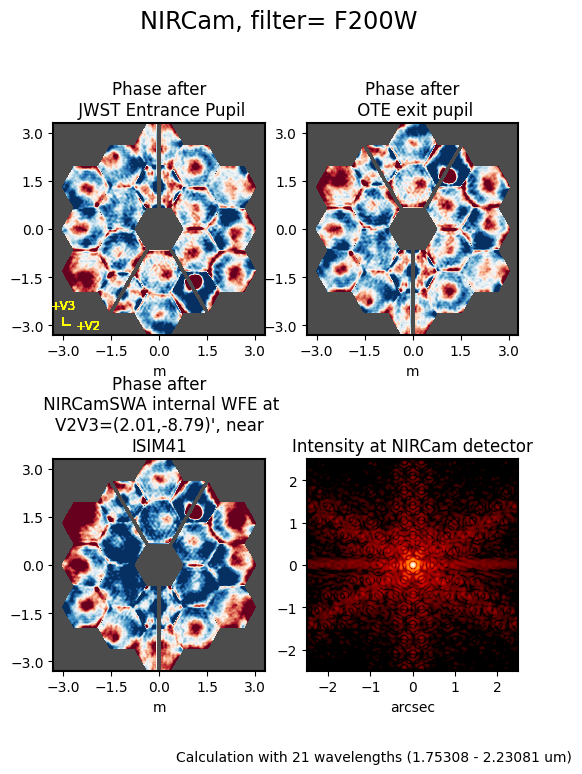

In [5]:
plt.figure(figsize=(6,8))
nrc.calc_psf(display=True)                          # will make plots with matplotlib showing the steps of the calculation

More complicated instrumental configurations are available by setting the instrument's attributes. For instance,
one can create an instance of MIRI and configure it for coronagraphic observations, thus:

In [6]:
miri = stpsf.MIRI()
miri.filter = 'F1065C'
miri.image_mask = 'FQPM1065'
miri.pupil_mask = 'MASKFQPM'
coron_psf = miri.calc_psf()

The Roman instruments work the same way: 

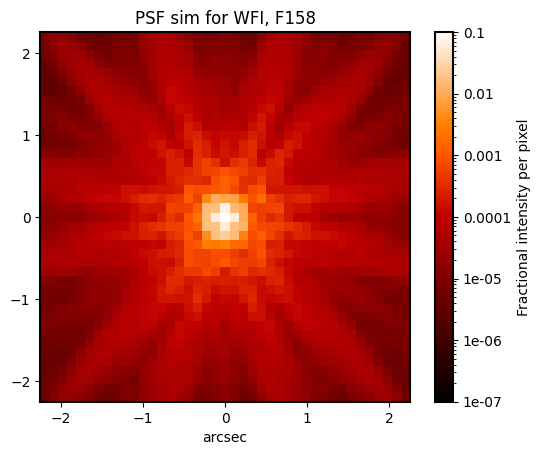

In [7]:
wfi = stpsf.WFI()
wfi.filter = 'F158'

wfipsf = wfi.calc_psf(fov_pixels=41)
stpsf.display_psf(wfipsf, ext='DET_SAMP')

## Configuring Instrument Models

Instruments have properties corresponding to their configurable options, typically the bandpass filter, detector, and optional image plane and pupil plane masks.

In [8]:
nrc.filter = 'F277W'

In [9]:
wfi.detector = 'SCA10'

The available options vary per instrument, reflecting the diversity and complexity of their scientific capabilities.  See the [JWST](jwst.html) and [Roman](roman.html) Instrument Model Details pages for further information. 

## Understanding output data products: File structure and FITS extensions

PSF outputs are returned as FITS HDULists with multiple extensions. In most cases, there will be four extensions,
for instance like this:

In [10]:
psf = nrc.calc_psf(fov_pixels=59)
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (236, 236)   float64   
  1  DET_SAMP      1 ImageHDU       142   (59, 59)   float64   
  2  OVERDIST      1 ImageHDU       194   (236, 236)   float64   
  3  DET_DIST      1 ImageHDU       195   (59, 59)   float64   


The first two extensions give the basic optical model outputs for the expected PSF in ideal coordinates with a perfect detector. The first extension is oversampled, and the second extension is binned down to the detector sampling pixel scale. 

Extensions 2 and 3 then add models for additional "real world" effects such as geometric distortion of the instruments, and detector charge transfer and interpixel capacitance. These are subtle effects so the difference can be difficult to see by eye, but this does make for slightly improved PSF model fidelity.

**In general, the last ("DET_DIST") FITS extension of the output PSF is the output data product that most
represents the PSF as actually observed on a real detector. Thus for many use cases that is the best output data product
to use for comparing to science data in observed `cal.fits` files.** 


The display and analyses functions in stpsf generally take an input parameter ``ext=`` to select between the FITS extensions. Either the extension number or name can be provided.

Extension 0 has oversampling factor =  4 	Pixelscale = 0.0157 arcsec/pix 	FWHM = 0.0883 arcsec
Extension 1 has oversampling factor =  1 	Pixelscale = 0.0629 arcsec/pix 	FWHM = 0.0976 arcsec
Extension 2 has oversampling factor =  4 	Pixelscale = 0.0157 arcsec/pix 	FWHM = 0.0972 arcsec
Extension 3 has oversampling factor =  1 	Pixelscale = 0.0629 arcsec/pix 	FWHM = 0.1061 arcsec


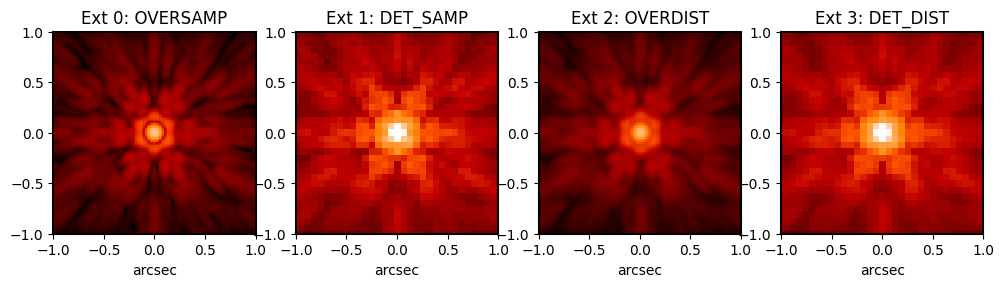

In [11]:
fig, axes = plt.subplots(figsize=(12,3), ncols=4)
for ext in range(len(psf)):
    stpsf.display_psf(psf, ext=ext, ax=axes[ext], title=f'Ext {ext}: {psf[ext].header["EXTNAME"]}',
                       imagecrop=2, colorbar=False)

    print(f"Extension {ext} has oversampling factor = ", psf[ext].header['OVERSAMP'], 
          f"\tPixelscale = {psf[ext].header['PIXELSCL']:.4f} arcsec/pix",
          f"\tFWHM = {stpsf.measure_fwhm(psf, ext=ext):.4f} arcsec")

In the above plots, the difference between oversampled and detector sampled is easily seen. 

The difference from the distortion effects is a bit more subtle. Note how the PSFS at right are a little softer or more blurred compared to the PSFs at left, and see the small differences in the computed FWHMs printed above. This part of the simulation models the detector charge transfer physics and inter-pixel capacitance which result in crosstalk between adjacent pixels.
Also included as part of the distortion is a model for optical geometric distortions (including for instance slight differences between X and Y pixel scales, small rotations and skews of the detector pixel axes, the very-slightly-different position angles for each NIRCam detector, etc.). 

## Customizing PSF Calculations: Wavelength Sampling and Source Spectra

### Input Source Spectra for Polychromatic PSFs

PSF calculations aim at realistic weighted broadband PSFs taking into account both the source spectrum and the instrumental spectral response.

The default source spectrum is, if [synphot](https://synphot.readthedocs.io/en/latest/) is installed, a 5700 K blackbody (roughly G2V star spectrum). Without [synphot](https://synphot.readthedocs.io/en/latest/), the default is a simple flat spectrum such that the same number of photons are detected at each wavelength.

You may choose a different illuminating source spectrum by specifying a ``source`` parameter in the call to ``calc_psf()``. The following are valid sources:

1. A [synphot.SourceSpectrum](https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html) object. This is the best option, providing maximum ease and accuracy, assuming you have `synphot` installed.  In this case, the `SourceSpectrum` object is combined with a `synphot.SpectralElement` for the selected instrument and filter to derive the effective stimulus in detected photoelectrons versus wavelength. This is then binned to the number of wavelengths set by the ``nlambda`` parameter, and iterated over for a polychromatic calculation.

    As a convenience, stpsf includes a function to retrieve an appropriate `synphot.SourceSpectrum` object for a given stellar spectral type from the PHOENIX or Castelli & Kurucz model libraries. These require data

In [12]:
src = stpsf.specFromSpectralType('G0V', catalog='phoenix')

miri = stpsf.MIRI()
miri.filter = 'F560W'
psf = miri.calc_psf(source=src)

2. A dictionary with keys ``"wavelengths"`` and ``"weights"`` giving the wavelengths in meters and the relative weights for each. The values should be numpy arrays or lists. In this case, the wavelengths and weights are used exactly as provided, without applying the instrumental filter profile.

In [13]:
src = {'wavelengths': [2.0e-6, 2.1e-6, 2.2e-6], 'weights': [0.3, 0.5, 0.2]}

nrc = stpsf.NIRCam()
nrc.filter='F200W'
psf = nrc.calc_psf(source=src)

(Deprecated, but still allowed for back compatibility: the source can also be specified as a tuple or list containing the numpy arrays ``(wavelength, weights)`` instead.)


### Wavelength sampling for Polychromatic PSFs

For polychromatic PSF calculations, by default the number of wavelengths `nlambda` is determined based on the filter bandwidth, using lookup tables of default values included in the reference data. (typically about 3, 9, or 20 wavelengths for narrow, medium, and wide filters, respectively). The `nlambda` parameter allows adjusting this, with a tradeoff between fidelity and computation speed.  See [this page](sampling.html) for further details on how the default values were determined. 

Note that using more wavelengths can be particularly useful for increasing fidelity at larger distances from the PSF core.

In [14]:
psf2 = nrc.calc_psf(source=src, nlambda=50)    # This will be higher fidelity, but will take longer to compute

### Making Monochromatic PSFs

To calculate a monochromatic PSF, just use the `monochromatic` parameter. Wavelengths are always specified in meters.

In [15]:
psf_mono = miri.calc_psf(monochromatic=9.876e-6)

## Customizing PSF Calculations: Array Size, Detector Locations, and Source Positions

### Array sizes and sampling

The size of a given PSF calculation output can be specified either in arcseconds or in pixels.  Pixels here refers to actual detector pixels, not oversampled simulated ones. 

In [16]:
psf1 = nrc.calc_psf(fov_arcsec=3)

psf2 = nrc.calc_psf(fov_pixels = 512)

The default oversampling factor is 4. This can be set by specifying the `oversample` parameter: 

In [17]:
psf3 = nrc.calc_psf(fov_pixels = 512, oversample=2)

In the latter example, for the oversampled extensions (extnames OVERSAMP and OVERDIST) you will get an array which is 1024 pixels on a side: 512 physical detector pixels, times an oversampling of 2.
The detector-sampled extensions (extnames DET_SAMP and DET_DIST) will be 512 detector pixels in size.

**By default, the PSF will be centered at the exact center of the output array**. This means that if the PSF is computed on an array with an odd number of pixels, the
PSF will be centered exactly on the central pixel. If the PSF is computed on an array with even size, it will be centered on the "crosshairs" at the intersection of the central four pixels. If you want to ensure one or the other of these cases, the simplest way is to directly specify the desired number of pixels as either odd or even.  


Alternatively, for fields of view given in arcseconds, you can optionally specify the desired parity. A number of non-instrument-specific calculation options can be adjusted through the `options` dictionary attribute on an instrument instance, for example as follows. Setting the parity options will ensure that a field of view specified in arcseconds is properly rounded to either odd or even when converted from arcsec to pixels.

In [18]:
nrc.options['parity'] = 'even'
psf1 = nrc.calc_psf(fov_arcsec=1)     # this will have an even number of pixels

nrc.options['parity'] = 'odd'
psf2 = nrc.calc_psf(fov_arcsec=1)     # this will have an odd number of pixels

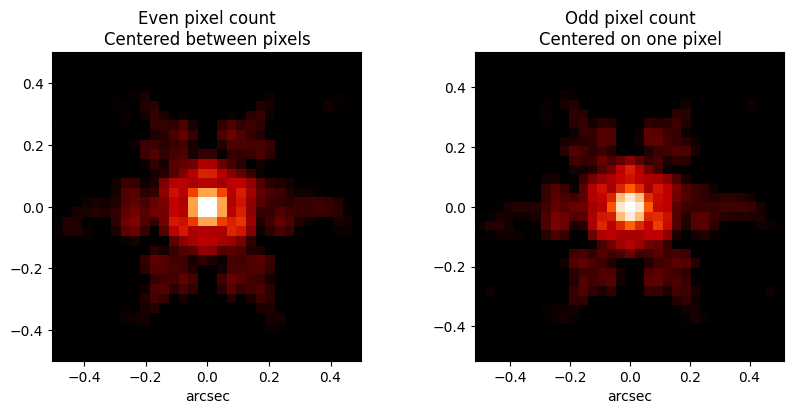

In [19]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)

stpsf.display_psf(psf1, ext=3, ax=axes[0], title=f'Even pixel count\nCentered between pixels',
                    colorbar=False, vmax=0.1, vmin=1e-4)
stpsf.display_psf(psf2, ext=3, ax=axes[1], title=f'Odd pixel count\nCentered on one pixel',
                    colorbar=False, vmax=0.1, vmin=1e-4)


Please note that these parity options apply to the number of *detector pixels* in your simulation. If you request oversampling, then the number of pixels in the output file for an oversampled array will be ``fov_pixels`` times ``oversampling``. Hence, if you request an odd parity with an even oversampling of, say, 4, then you would get an array with a total number of data pixels that is even, but that correctly represents the PSF located at the center of an odd number of detector pixels.


### Detector Positions

You can think of the simulation output as a model for a PSF on a particular subarray within the pixels in a given detector or image. To account for the small but nonzero variations in PSFs across the field of view, you can specify a position within the detector. By default, the PSF calculation is configured for the center of the selected detector, which will often give a reasonable match to PSFs across the detector. This may be sufficient for many use cases, depending on the particular science needs.

*Setting the detector position affects the simulated instrument wavefront error, but does NOT affect the position of the point source within the output file*.

To specify a particular detector region of interest, set the `detector_position` attribute:

In [20]:
nrc.detector_position = (1400, 200)  # in X, Y order for pixel coordinates here. 

Another way of specifying positions is by named detector apertures, for example named subarrays, as recorded in the [SIAF](https://pysiaf.readthedocs.io/en/latest/).  The function `set_position_from_aperture_name` will configure the instrument model to represent that subarray. Note that when a subarray aperture is configured, the `detector_position` parameter then will refer to pixel coordinates *in that subarray*. 

In [21]:
nrc.set_position_from_aperture_name('NRCA2_SUB320')

print(nrc.detector, nrc.aperturename)
print(nrc.detector_position, "This represents the center pixel of that 320x320 subarray!")

NRCA2 NRCA2_SUB320
(160, 160) This represents the center pixel of that 320x320 subarray!


### Input Source Positions and Offsets

The PSF may be shifted off-center by adjusting the offset of the simulated point source. This can be done either in polar or Cartesian coordinates:

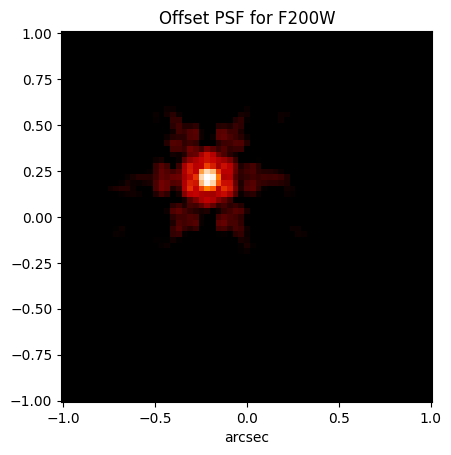

In [22]:
nrc.options['source_offset_r'] = 0.3         # offset in arcseconds
nrc.options['source_offset_theta'] = 45.     # degrees counterclockwise from instrumental +Y in the science frame

psf = nrc.calc_psf(fov_arcsec=2)
stpsf.display_psf(psf, ext=3, title=f'Offset PSF for {nrc.filter}', colorbar=False, vmax=0.1, vmin=1e-4)


Similarly, in Cartesian coordinates:


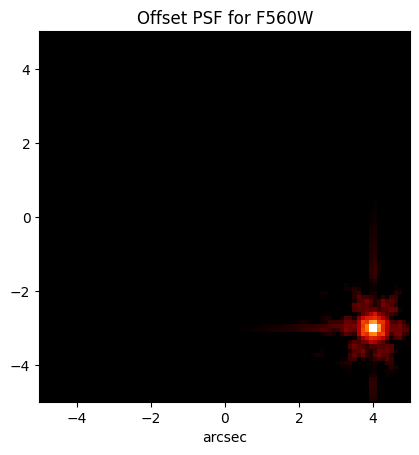

In [23]:
miri.options['source_offset_x'] = 4      # offset is in arcsec
miri.options['source_offset_y'] = -3     # offset is in arcsec

psf = miri.calc_psf(fov_arcsec=10)
stpsf.display_psf(psf, ext=3, title=f'Offset PSF for {miri.filter}', colorbar=False, vmax=0.1, vmin=1e-4)


*Setting the source offset affects the position of the point source in the output pixel grid, but does NOT affect the simulated instrument wavefront error*.


The option ``source_offset`` defines “the location of the point source within the simulated subarray”. It doesn’t affect the WFE, but it does affect the position offset of the source relative to any focal plane elements such as a coronagraph mask or spectrograph slit. 

#### A note on source positions for coronagraphic modes
For coronagraphic modes, the coronagraph occulter is by default assumed to be at the center of the output array. Therefore, the above options let you offset the source away from the coronagraph.

Alternatively, instead of offsetting the source, we could offset the coronagraph mask in the opposite direction. This can be done with the ``coron_shift_x`` and ``coron_shift_y`` options. These options will offset a coronagraphic mask in order to produce PSFs centered in the output image, rather than offsetting the PSF. Both options, ``coron_shift``  and ``source_offset`` give consistent results, in different coordinate frames. Using the same ``source_offset`` values above, we can offset a coronagraphic mask:

```
>>> instrument.options['coron_shift_x'] = -4        # offset is in arcsec
>>> instrument.options['coron_shift_y'] = +3        # offset is in arcsec
# note, these have opposite sign convention vs source_offset,
# due to representing a shift of the telescope instead of the star 
```

If these options are set, the offset is applied relative to the central coordinates as defined by the output array size and parity (described just above). Let's create output using both methods and compare:

In [24]:
# configure for coronagraphic calculation, and make a PSF centered on the coronagraph
miri = stpsf.MIRI()
miri.filter='F1065C'
miri.image_mask='FQPM1065'
psf_no_offset = miri.calc_psf(fov_arcsec=10)

# Offset the source away from the mask
miri.options['source_offset_x'] = .6      # offset is in arcsec
miri.options['source_offset_y'] = -.3     # offset is in arcsec
psf_source_offset = miri.calc_psf(fov_arcsec=10)

# Offset the coronagraph mask from the source instead
del miri.options['source_offset_x'] 
del miri.options['source_offset_y'] 
miri.options['coron_shift_x'] = -.6        # offset is in arcsec
miri.options['coron_shift_y'] = +.3        # offset is in arcsec
psf_mask_offset = miri.calc_psf(fov_arcsec=10)

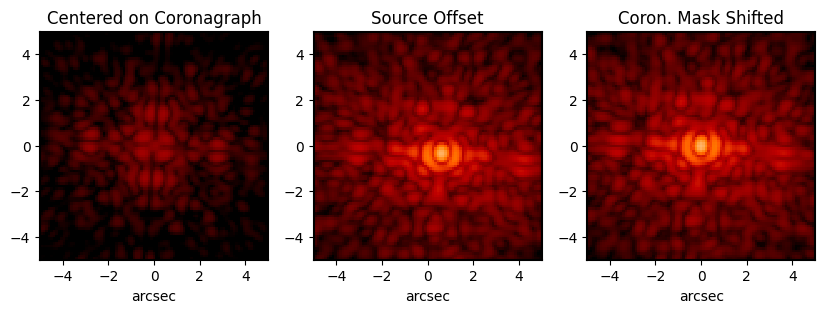

In [25]:
fig, axes = plt.subplots(figsize=(10,4), ncols=3)

stpsf.display_psf(psf_no_offset, ext=3, ax=axes[0], title=f'Centered on Coronagraph', colorbar=False)
stpsf.display_psf(psf_source_offset, ext=3, ax=axes[1], title=f'Source Offset', colorbar=False)
stpsf.display_psf(psf_mask_offset, ext=3, ax=axes[2], title=f'Coron. Mask Shifted', colorbar=False)


## Customizing PSF Calculations: PSF Normalizations and Flux Calibrations

By default, PSFs are normalized to total intensity = 1.0 at the entrance pupil (i.e. at the JWST OTE primary). For typical imaging PSFs this is similar to being normalized as `sum(PSF)==1`. Such a PSF calculated for an infinite aperture would thus have integrated intensity = 1.0. A PSF calculated on any smaller finite subarray will have some finite encircled energy less than one. 

For instance, at 2 microns a 10 arcsecond size FOV will enclose about 99% of the energy of the PSF:,

In [26]:
psf = nrc.calc_psf(fov_arcsec=10)

print(f"PSF sum within {psf[0].header['FOV']:.1f} arcsec box for "
      f"{psf[0].header['FILTER']}: {psf[0].data.sum():.3f}")

PSF sum within 10.0 arcsec box for F200W: 0.992


Note that if there are any additional obscurations in the optical system (such as coronagraph masks, spectrograph slits, etc), then the fraction of light that reaches the final focal plane will typically be significantly less than 1, even if calculated on an arbitrarily large aperture. For instance the NIRISS NRM mask has a throughput of about 15%, so a PSF calculated in this mode with the default normalization will have integrated total intensity approximately 0.15 over a large FOV:

In [27]:
nis = stpsf.NIRISS()
nis.pupil_mask = 'MASK_NRM'
nis.filter = 'F430M'

psf = nis.calc_psf(fov_arcsec=10)

print(f"PSF sum within {psf[0].header['FOV']:.1f} arcsec box for "
      f"{psf[0].header['FILTER']} + {psf[0].header['PUPIL']} : {psf[0].data.sum():.3f}")

PSF sum within 10.0 arcsec box for F430M + MASK_NRM : 0.153


### A note on normalizations for certain NIRISS long-wave filters

The NIRISS filters F277W and longer must be used, even in regular imaging mode, with a [NIRISS pupil wheel mask called `CLEARP`](https://jwst-docs.stsci.edu/jwst-near-infrared-imager-and-slitless-spectrograph/niriss-instrumentation/niriss-filters#gsc.tab=0), which leads to a ~18% loss in throughput for those filters. STPSF models this effect automatically, which leads to PSF sums around 0.8 for these filters by default. This is a case for which you might typically wish to select a different normalization option. 

In [28]:
nis = stpsf.NIRISS()
nis.filter = 'F430M'

psf = nis.calc_psf(fov_arcsec=10)

print(f"PSF sum within {psf[0].header['FOV']:.1f} arcsec box for "
      f"{psf[0].header['FILTER']} + {psf[0].header['PUPIL']} : {psf[0].data.sum():.3f}")

PSF sum within 10.0 arcsec box for F430M + CLEARP : 0.828


### Selecting other normalization options

If a different normalization is desired, there are a few options that can be set in calls to calc_psf.  For example, setting `normalize='last'` performs the normalization at the end of the calculation. This forces the output (i.e. the PSF on whatever finite subarray) to have a sum of precisely 1.0.:

In [29]:
psf = nis.calc_psf(fov_arcsec=10, normalize='last')

print(f"PSF sum within {psf[0].header['FOV']:.1f} arcsec box for "
      f"{psf[0].header['FILTER']} + {psf[0].header['PUPIL']} : {psf[0].data.sum():.3f}")

PSF sum within 10.0 arcsec box for F430M + CLEARP : 1.000


If you want the sum of the PSF to be 1.0 in an infinite aperture (even for cases with optical masks), that can be achieved by setting `normalize='exit_pupil'` to apply the normalization at the exit pupil of the optical system. This normalization takes out the effect of any pupil obscurations such as coronagraph masks, spectrograph slits or pupil masks, the NIRISS NRM mask, and so forth. However it still leaves in the effect of any finite FOV. In other words, PSFs calculated in this mode will have integrated total intensity = 1.0 over an infinitely large FOV, even after the effects of any obscurations.

This normalization makes the encircled energy curve for our example NIRISS PSF become more consistent with that of the NIRCam example above: 

In [30]:
psf = nis.calc_psf(fov_arcsec=10, normalize='exit_pupil')

print(f"PSF sum within {psf[0].header['FOV']:.1f} arcsec box for "
      f"{psf[0].header['FILTER']} + {psf[0].header['PUPIL']} : {psf[0].data.sum():.3f}")

PSF sum within 10.0 arcsec box for F430M + CLEARP : 0.979


The exit pupil option is particularly useful for tasks deriving aperture corrections for coronagraphic or masked modes. 

### An aside on throughputs and normalization: 

Note that by design STPSF does not track or model the absolute throughput of any instrument. Consult the JWST Exposure Time Calculator and associated reference material if you are interested in absolute throughputs. Instead STPSF simply allows normalization of output PSFs’ total intensity to 1 at either the entrance pupil, exit pupil, or final focal plane. When used to generate monochromatic PSFs for use in the JWST ETC, the entrance pupil normalization option is selected. Therefore STPSF first applies the normalization to unit flux at the primary mirror, propagates it through the optical system ignoring any reflective or transmissive losses from mirrors or filters (since the ETC throughput curves take care of those), and calculates only the diffractive losses from slits and stops. Any loss of light from optical stops (Lyot stops, spectrograph slits or coronagraph masks, the NIRISS NRM mask, etc.) will thus be included in the STPSF calculation. Everything else (such as reflective or transmissive losses, detector quantum efficiencies, etc., plus scaling for the specified target spectrum and brightness) is the ETC’s job. This division of labor has been coordinated with the ETC team and ensures each factor that affects throughput is handled by one or the other system but is not double counted in both.

To support realistic calculation of broadband PSFs however, STPSF does include normalized copies of the relative spectral response functions for every filter in each instrument. These are included in the STPSF data distribution, and are derived behind the scenes from the same reference database as is used for the ETC. These relative spectral response functions are used to make a proper weighted sum of the individual monochromatic PSFs in a broadband calculation: weighted *relative to the broadband total flux of one another*, but still with no implied absolute normalization.

## Customizing PSF Calculations: output formats and logging

The following options are less commonly used.

### Controlling output log text

STPSF can output a log of calculation steps while it runs, which can be displayed to the screen and optionally saved to a file. This is useful for verifying or debugging calculations. To turn on log display, just run


In [31]:
stpsf.setup_logging('info')

STPSF log messages of level INFO and above will be shown.
STPSF log outputs will be directed to the screen.


This results in verbose output describing calculation steps, which can be useful for diagnostics or debugging. 

In [32]:
psf = nrc.calc_psf(nlambda=1)

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F200W...
[  poppy] PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 1
[stpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: JWST+NIRCam
[  poppy] JWST Entrance Pupil: Loaded amplitude transmission from /Users/mperrin/software/stpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[  poppy] JWST Entrance Pupil: Loaded OPD from /Users/mperrin/software/stpsf-data/JWST_OTE_OPD_cycle1_example_2022-07-30.fits
[stpsf] Loading field dependent model parameters from /Users/mperrin/software/stpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
[stpsf] Calculating field-dependent OTE OPD at v2 = 1.553 arcmin, v3 = -8.110 arcmin
[  poppy] Added pupil plane: JWST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] Added pupil plane: NIRCamSWA internal WFE at V2V3=(1.55,-8.11)', near IS

The `setup_logging` function allows selection of the level of log detail following the standard Python logging system (`DEBUG, INFO, WARN, ERROR`). To disable all printout of log messages except for errors, set

In [33]:
stpsf.setup_logging(level='ERROR')

STPSF log messages of level ERROR and above will be shown.
STPSF log outputs will be directed to the screen.


Setting logging to None disables log outputs again. 

In [34]:
stpsf.setup_logging(None)

### Controlling which extensions are computed during PSF calculations

As explained above, STPSF by default calculates PSFs on a finer grid than the detector's native pixel scale, then also bins down to detector sampling, then adds models for non-ideal detector effects and distortions, and the output product is a multi-extension FITS file containing all those outputs as image extensions. It is sometimes useful to toggle off some of these outputs to reduce calculation costs or data storage volumes. 

#### Output options for sampling
You can select whether the output data should include this oversampled image, a copy that has instead been rebinned down to match the detector scale, or optionally both. This is done using the ``options['output_mode']`` parameter.

In [35]:
nrc.options['output_mode'] = 'detector sampled'
psf = nrc.calc_psf()       # the 'psf' output will contain only the detector-sampled PSF, formatted as a FITS HDUlist
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DET_SAMP      1 PrimaryHDU     142   (163, 163)   float64   
  1  DET_DIST      1 ImageHDU       196   (163, 163)   float64   


In [36]:
nrc.options['output_mode'] = 'oversampled'
psf = nrc.calc_psf()       # the 'psf' output will contain only the oversampled PSF, formatted as a FITS HDUlist
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     141   (652, 652)   float64   
  1  OVERDIST      1 ImageHDU       195   (652, 652)   float64   


In [37]:
nrc.options['output_mode'] = 'both'
psf = nrc.calc_psf()       # This is the default behavior containing all outputs
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     141   (652, 652)   float64   
  1  DET_SAMP      1 ImageHDU       143   (163, 163)   float64   
  2  OVERDIST      1 ImageHDU       195   (652, 652)   float64   
  3  DET_DIST      1 ImageHDU       196   (163, 163)   float64   


#### Disabling distortion models

If the distorted products are not needed, the computation of the OVERDIST and DET_DIST extensions can be toggled off by setting `add_distortion=False`.  Note, this will reduce model output fidelity, so scientific judgement should be applied about the tradeoff. 

In [38]:
psf = nrc.calc_psf(fov_arcsec=3, add_distortion=False)
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     141   (388, 388)   float64   
  1  DET_SAMP      1 ImageHDU       143   (97, 97)   float64   
